In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings, copy, time, glob, pickle
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from preprocessing import process_game_data
from sequencing import get_sequences, get_minibatches, iterate_minibatches, subsample_sequence
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [2]:
all_games_id = [i.split('/')[-1].split('.')[0] for i in glob.glob('../data/*.pkl')]

In [3]:
# all_games_id = ['0021500024']

In [4]:
event_threshold = 100
subsample_factor = 2
# single_game = process_game_data(game_id, events_df, event_threshold, subsample_factor)

game_files = './all_games.pkl'
if os.path.isfile(game_files):
    with open(game_files, 'rb') as f:
        single_game = pickle.load(f)
else:
    single_game = process_game_data(Data, all_games_id, event_threshold, subsample_factor)
    with open(game_files, 'wb') as f:
        pickle.dump(single_game, f)
print('Final number of events:', len(single_game))

2018-05-17 10:12:03,137 | INFO : working on game 0021500066 | 1 out of total 42 games
2018-05-17 10:12:23,423 | INFO : working on game 0021500529 | 2 out of total 42 games
2018-05-17 10:12:43,167 | INFO : working on game 0021500042 | 3 out of total 42 games
2018-05-17 10:12:59,930 | INFO : working on game 0021500115 | 4 out of total 42 games
2018-05-17 10:13:20,171 | INFO : working on game 0021500096 | 5 out of total 42 games
2018-05-17 10:13:42,731 | INFO : working on game 0021500649 | 6 out of total 42 games
2018-05-17 10:14:01,100 | INFO : working on game 0021500383 | 7 out of total 42 games
2018-05-17 10:14:25,725 | INFO : working on game 0021500272 | 8 out of total 42 games
2018-05-17 10:14:44,426 | INFO : working on game 0021500075 | 9 out of total 42 games
2018-05-17 10:15:02,086 | INFO : working on game 0021500355 | 10 out of total 42 games
2018-05-17 10:15:25,444 | INFO : working on game 0021500421 | 11 out of total 42 games
2018-05-17 10:15:49,864 | INFO : working on game 002

         1  -169724388.5778             +nan
         2  -147823214.3897   +21901174.1881
         3  -142410113.7409    +5413100.6488
         4  -141242212.0875    +1167901.6534
         5  -140517954.4937     +724257.5938
         6  -139917415.6611     +600538.8326
         7  -139549793.8034     +367621.8577
         8  -139299729.1151     +250064.6883
         9  -139119939.6876     +179789.4275
        10  -139001026.6960     +118912.9917
        11  -138924595.8095      +76430.8864
        12  -138875215.8216      +49379.9879
        13  -138841163.5742      +34052.2475
        14  -138817312.1466      +23851.4276
        15  -138799686.1249      +17626.0217
        16  -138785914.7344      +13771.3905
        17  -138774300.2092      +11614.5252
        18  -138764126.0092      +10174.2000
        19  -138754534.4640       +9591.5452
        20  -138744864.4392       +9670.0249
        21  -138734365.4461      +10498.9931
        22  -138721986.9518      +12378.4943
        23

2018-05-17 11:21:58,771 | INFO : Assigning roles by cosine method.
2018-05-17 11:21:58,772 | INFO : Training for player_inds: [5, 6, 7, 8, 9] with iterations: 130


         1  -184791489.4785             +nan
         2  -157711793.9455   +27079695.5330
         3  -152663993.4817    +5047800.4638
         4  -152032760.6717     +631232.8100
         5  -151775921.3740     +256839.2977
         6  -151576813.8406     +199107.5334
         7  -151414960.9051     +161852.9355
         8  -151277234.4549     +137726.4502
         9  -151155492.4309     +121742.0240
        10  -151049890.3215     +105602.1094
        11  -150958873.9815      +91016.3401
        12  -150882386.9971      +76486.9843
        13  -150820345.7043      +62041.2929
        14  -150773539.6066      +46806.0977
        15  -150738057.7623      +35481.8443
        16  -150711180.0121      +26877.7502
        17  -150690349.5805      +20830.4316
        18  -150673318.0010      +17031.5795
        19  -150659110.2262      +14207.7747
        20  -150647110.3465      +11999.8797
        21  -150636310.4056      +10799.9410
        22  -150627014.1759       +9296.2297
        23

2018-05-17 12:36:30,433 | INFO : Total HMM training took 130.00432457129162mins
Final number of events: 6485


#### Show the plot, for the sake of comparison with processed moment later on

In [5]:
game_id = all_games_id[0]
Plot = PlotGame(game_id, main_dir, game_dir)
# for i in range(plotn): 
# Plot.load_moment2img(game_data, event_number=0, moment_number=0, return_img=True)

In [6]:
plt_ind = 0

0


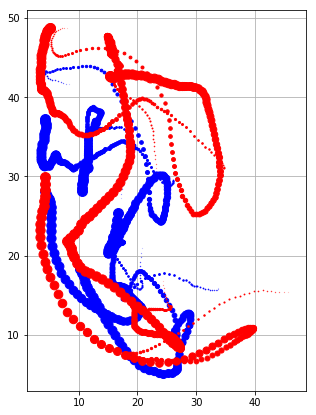

In [ ]:
# manual plot check
print(plt_ind)
plot_check(single_game, plt_ind)
plt_ind += 1

#### Build graph and starts training for all single policies

In [ ]:
sequence_length = 50
overlap = 25
batch_size = 64

hyper_params = {'batch_size': batch_size,
                'sequence_length': sequence_length,
                'overlap': overlap,
                'state_size': 256,
                'input_dim': 179,
                'learning_rate': 0.0005,
                'n_epoch': int(1e3)}

train_all_single_policies(single_game, hyper_params, models_path)

2018-05-17 12:39:06,018 | INFO : Training with hyper parameters: 
{'batch_size': 64, 'sequence_length': 50, 'overlap': 25, 'state_size': 256, 'input_dim': 179, 'learning_rate': 0.001, 'n_epoch': 1000}
2018-05-17 12:39:06,019 | INFO : Wroking on policy 0
2018-05-17 12:39:06,714 | INFO : train len: 20546 | test shape: 5137
2018-05-17 12:39:07,789 | INFO : Horizon 0 ==========
2018-05-17 12:39:21,554 | INFO : Epoch 0    | loss: 55.04    | time took: 12.43s | validation loss: 36.03   
2018-05-17 12:59:57,290 | INFO : Epoch 100  | loss: 1.94     | time took: 12.37s | validation loss: 2.15    
2018-05-17 13:20:35,711 | INFO : Epoch 200  | loss: 1.53     | time took: 12.35s | validation loss: 2.19    
2018-05-17 13:41:14,299 | INFO : Epoch 300  | loss: 1.21     | time took: 12.34s | validation loss: 2.37    
2018-05-17 14:01:52,758 | INFO : Epoch 400  | loss: 1.02     | time took: 12.35s | validation loss: 2.44    
2018-05-17 14:22:32,184 | INFO : Epoch 500  | loss: 0.81     | time took: 12.4

### Check performance

In [ ]:
# pad short sequence and chunk long sequence with overlaps
policy = 0
train, target = get_sequences(single_game, policy, sequence_length, overlap)
# create train and test set
p = 0.8 # train percentage
divider = int(len(train)*p)
train_game, test_game = np.copy(train[:divider]), np.copy(train[divider:])
train_target, test_target = np.copy(target[:divider]), np.copy(target[divider:])
Model = ImportGraph('policy0/')

In [ ]:
n = 0

In [ ]:
# manual plot check
plot_check(train_game, n)
n+=1

In [ ]:
# use while loop to make sure the 
train_batches = get_minibatches(train_game, train_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(train_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(train_game)//batch_size))

input_xi, output_yi = train_batches

y_pred = Model.forward_pass(input_xi[check_ind], h=1)
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')#, pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning
    - from each sample to next sample theres not much change, subsample them 

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 